In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json

We're only interested in users who use the "Favorites" feature of the app. This narrows our data down to a reasonable size and gears the app towards users that are invested in their experience. This is apparent in the following chart.

In [2]:
# Read in data for all users
data = pd.read_csv('Vol3CleanedData.csv')
users = data.groupby('user_id')
sizes_list = []
base = 10
# Count how many words each user has studied.
for group_key in users.groups.keys():
    user = users.get_group(group_key)
    size = base * round(len(user)/base)
    sizes_list.append(size)

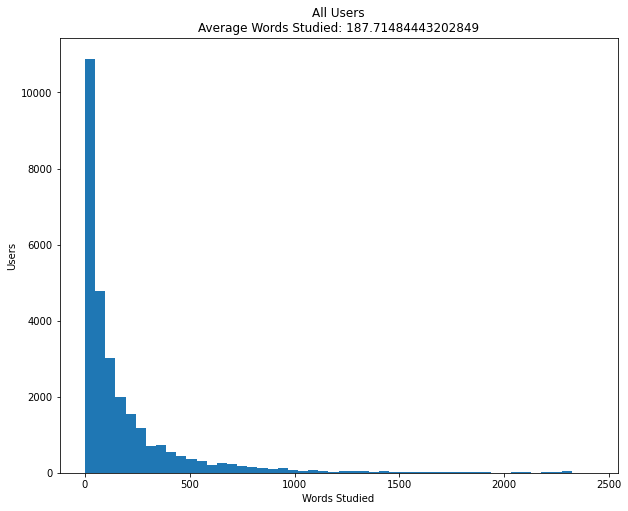

In [3]:
# Plot data as a histogram
plt.rcParams["figure.figsize"] = (10,8)
plt.hist(sizes_list, bins=50)
plt.title("All Users\nAverage Words Studied: "+str(np.mean(sizes_list)))
plt.xlabel("Words Studied")
plt.ylabel("Users")
plt.show()

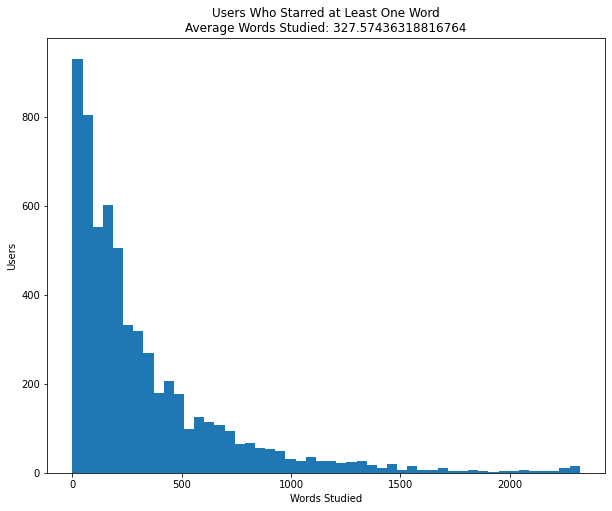

In [4]:
# Read in data for users who have starred at least one word
data = pd.read_csv('Vol3StarredData.csv')
users = data.groupby('user_id')
sizes_list = []
base = 10
# Count how many words each user has studied.
for group_key in users.groups.keys():
    user = users.get_group(group_key)
    size = base * round(len(user)/base)
    sizes_list.append(size)
# Plot data as a histogram
plt.hist(sizes_list, bins=50)
plt.title("Users Who Starred at Least One Word\nAverage Words Studied: "+str(np.mean(sizes_list)))
plt.xlabel("Words Studied")
plt.ylabel("Users")
plt.rcParams["figure.figsize"] = (10,8)
plt.show()

Next, we read in the Embark course data for Spanish-English learning. This was obtained with a GET request to the following query:
https://tall.global/api/v2/course/1?to=es_ES&from=en_US

In [5]:
# Get the course data from the file
with open('spanish_course_data.json', encoding='utf-8') as f:
     course_data = json.load(f)
# Convert to a Pandas DataFrame object to better handle the data
df = pd.DataFrame(columns=['Spanish', 'English', 'Tasks'])
for concept_id in course_data['vocabConcepts']:
    # Not every Spanish word has a translation to English, so we skip those
    try:
        df.loc[concept_id] = [course_data['vocabConcepts'][concept_id]['textInTargetLanguage'], 
                              course_data['vocabConcepts'][concept_id]['textInNativeLanguage'], 
                              np.array([])] # Initialize with an empty array we fill later
    except:
        print(concept_id) # Let us know which concepts have no translation
        continue

/home/reece/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


989298240
989298599
989298598
989298601
989298600
989221046
989221047
989221042
989221041
989221048
989221038
989221039
989237315
989237300
989237301
989237298
989237310
989270522
989237719
989237720
989237598
989237599
989268639
989268618
989268578
989219362
989219803
989219800
989219801
989236086
989236087
989236091
989236088
989219660
989219613
989219066
989219021
989219309
989219282
989292939
989251938
989251939
989219182
989220438
989212254
989236788
989236789
989236786
989236787
989212208
989236783
989236780
989236781
989212203
989236779
989212180
989212177
989220083
989219919
989219844
989234089
989266758
989218724
989218688
989218679
989267324


In [6]:
# Display the DataFrame
df

,Spanish,English,Tasks
989166325,preguntar,to ask (a question),[]
989166324,joven,young,[]
989166326,pedir,to ask (for something),[]
989166321,traducir,to translate,[]
16389,resultar,to result,[]
...,...,...,...
989267258,Este,Hmm,[]
989267238,el tomar,making,[]
989267220,a través del,through the,[]
989267219,a través,through,[]


In [7]:
# Populate the DataFrame's 'Tasks' column with tasks associated with the vocab concept
for task_id in course_data['tasks']:
    for concept in df.index:
        # For some reason, not every Task has a vocabStudyListConceptId, so we skip those.
        try:
            if int(concept) in course_data['tasks'][task_id]["vocabStudyListConceptIds"]:
                df.loc[concept]['Tasks'] = np.append(df.loc[concept]['Tasks'], task_id)
        except KeyError:
            continue

In [8]:
# Make a new DataFrame that only contains words that have Tasks
    # These are the words that missionaries can learn
has_task_df = pd.DataFrame(columns=['Spanish', 'English', 'Tasks'])
for concept_id in df.index:
    if len(df.loc[concept_id]['Tasks']) > 0:
        has_task_df.loc[concept_id] = df.loc[concept_id]

In [9]:
# Display the DataFrame
has_task_df

,Spanish,English,Tasks
16389,resultar,to result,[16]
7,Sacerdocio Aarónico,Aaronic Priesthood,"[17, 51]"
9,abdomen,abdomen,[83]
12,habilidad,ability,"[22, 38, 55, 77]"
14,aborto,abortion,[45]
...,...,...,...
16293,imprimir,to print,[52]
49064,compañero,companion (male),[5]
49065,compañera,companion (female),[5]
49066,doctor,doctor (male),[77]


Here, we count the number of times each concept has been studied, so we can see a distribution of how often words are learned.

In [10]:
concepts = data.groupby('concept_id')
sizes_list = []
for group_key in concepts.groups.keys():
    concept = concepts.get_group(group_key)
    sizes_list.append(len(concept))

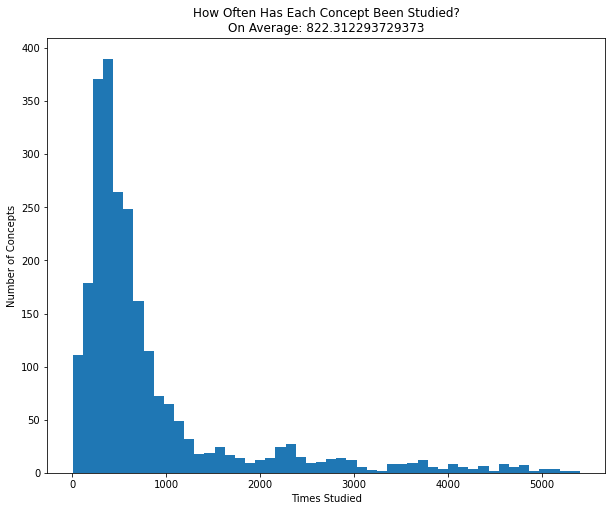

In [11]:
plt.hist(sizes_list, bins=50)
plt.title("How Often Has Each Concept Been Studied?\nOn Average: "+str(np.mean(sizes_list)))
plt.xlabel("Times Studied")
plt.ylabel("Number of Concepts")
plt.rcParams["figure.figsize"] = (10,8)
plt.show()

Thus there are many concepts that have hardly been studied, but after about 1500, there is a relatively equal ditribution.

Next we display which words have been studied the most often.

In [12]:
# Create and populate a dictionary of concept_id's along with how often they've been studied
concept_dict = {}
for group_key in concepts.groups.keys():
    concept = concepts.get_group(group_key)
    concept_dict[group_key] = len(concept)
# Sort concepts by number of times studied
sorted_concepts = sorted(concept_dict.items(), key=lambda x:x[1])[::-1]

In [13]:
# Display the top 10 studied words
for concept_id, times_studied in sorted_concepts[:10]:
    if str(concept_id) in df.index:
        print(df.loc[str(concept_id)]['English'], "has been studied by", times_studied, "users.")

Jesus Christ has been studied by 5408 users.
family has been studied by 5383 users.
Good morning has been studied by 5268 users.
name has been studied by 5253 users.
to know (familiarity) has been studied by 5153 users.
Good afternoon has been studied by 5152 users.
good has been studied by 5141 users.
Good evening has been studied by 5123 users.
missionary (female) has been studied by 5070 users.
missionary (male) has been studied by 5038 users.


The following is a result of the Random Forest predictions; that is, how often did we get each word correct?

In [14]:
random_forest_results = {425: 2, 131: 6, 299: 7, 429: 2, 514: 6, 841: 2, 1144: 5, 1614: 7, 1852: 3, 2171: 2, 2535: 3, 2716: 4, 3135: 2, 3136: 2, 3461: 4, 3657: 7, 3678: 5, 3692: 5, 3735: 4, 4212: 2, 5042: 5, 5136: 6, 5261: 4, 5347: 4, 5615: 3, 5620: 6, 5819: 8, 5887: 9, 14328: 14, 6214: 4, 6234: 5, 6304: 2, 433: 2, 2484: 1, 3452: 2, 3597: 1, 735: 7, 134: 9, 360: 2, 1345: 3, 1348: 3, 1380: 1, 2221: 2, 2229: 2, 2583: 4, 3310: 1, 3332: 1, 3339: 2, 11737: 2, 4058: 2, 4064: 1, 4065: 3, 4160: 3, 4168: 5, 4330: 3, 4337: 1, 4688: 3, 5033: 2, 5048: 4, 5186: 1, 5224: 6, 5247: 4, 5309: 10, 5340: 1, 5359: 1, 13749: 2, 13748: 1, 13873: 3, 5748: 2, 6085: 1, 6092: 1, 6093: 2, 6157: 2, 6159: 1, 6170: 2, 87: 1, 550: 2, 2766: 2, 5841: 5, 15522: 4, 201: 2, 230: 2, 1120: 3, 1367: 3, 1573: 4, 1803: 2, 2385: 1, 2515: 7, 3239: 1, 3422: 4, 3514: 3, 3710: 1, 3900: 2, 4725: 6, 4788: 3, 4789: 3, 4908: 1, 4943: 1, 5039: 3, 5165: 6, 5232: 6, 5379: 6, 5511: 1, 5665: 3, 5667: 3, 5830: 2, 5900: 5, 6036: 1, 6257: 2, 14464: 3, 15933: 3, 4099: 2, 5086: 5, 297: 2, 1788: 3, 1839: 1, 1841: 2, 1967: 2, 2180: 6, 4009: 2, 4976: 5, 5105: 7, 5327: 1, 5895: 1, 1984: 7, 2147: 6, 4573: 1, 4735: 1, 915: 3, 4197: 1, 633: 1, 794: 1, 1061: 2, 1289: 4, 1539: 5, 1859: 2, 1956: 4, 2128: 1, 2500: 2, 2907: 3, 3249: 2, 3390: 1, 3523: 1, 3610: 3, 4102: 2, 4230: 3, 4308: 1, 4727: 3, 4741: 2, 4756: 4, 4985: 3, 5027: 4, 5154: 6, 5185: 3, 5236: 6, 5380: 2, 14227: 2, 6099: 1, 6102: 2, 7: 2, 154: 1, 256: 1, 391: 1, 395: 1, 967: 2, 1062: 2, 1063: 2, 1074: 1, 1285: 3, 1889: 2, 1901: 1, 2081: 1, 2089: 2, 2708: 2, 2767: 1, 2772: 2, 2773: 1, 3033: 2, 3037: 1, 3041: 1, 3504: 2, 3533: 2, 3534: 1, 3537: 2, 3540: 1, 3632: 1, 4166: 4, 4182: 1, 4186: 3, 4321: 1, 4462: 1, 4463: 2, 5005: 1, 5006: 1, 5008: 4, 5237: 6, 5251: 1, 5538: 6, 5539: 1, 6156: 2, 6163: 2, 86: 1, 93: 1, 305: 1, 309: 1, 533: 2, 534: 6, 658: 1, 1366: 2, 2318: 3, 2489: 1, 3681: 3, 3688: 4, 3879: 6, 4317: 2, 4755: 2, 13202: 4, 5025: 5, 5047: 6, 5084: 2, 5143: 2, 5252: 4, 5571: 1, 5714: 1, 6314: 3, 952: 2, 1002: 1, 1288: 2, 1660: 5, 1673: 1, 1900: 2, 2059: 3, 2371: 3, 2479: 1, 2851: 4, 2867: 1, 3097: 2, 3518: 1, 3729: 9, 3737: 4, 4245: 4, 5055: 1, 194: 1, 318: 1, 538: 4, 875: 5, 1199: 5, 1201: 4, 1850: 2, 1994: 4, 2705: 2, 3111: 3, 3529: 1, 3544: 1, 12136: 4, 3969: 4, 3981: 2, 4576: 10, 4963: 4, 5149: 3, 5242: 2, 5654: 5, 5657: 1, 2103: 1, 2155: 4, 3543: 2, 724: 1, 1486: 4, 1617: 2, 3419: 2, 3761: 1, 3998: 12, 5248: 13, 5341: 3, 5377: 5, 5547: 10, 5579: 6, 5791: 5, 6259: 3, 14565: 2, 922: 7, 1332: 1, 5264: 7, 5662: 2, 6385: 3, 3090: 1, 12: 4, 98: 2, 902: 1, 973: 2, 1307: 1, 1522: 2, 2223: 1, 2243: 2, 3782: 2, 4498: 2, 4757: 1, 5766: 2, 6237: 2, 218: 3, 740: 1, 1645: 2, 1960: 2, 3556: 2, 3565: 5, 3569: 4, 3571: 3, 3573: 3, 4535: 6, 5531: 1, 5707: 2, 5873: 3, 6313: 6, 306: 3, 1704: 2, 3856: 5, 129: 3, 407: 6, 412: 2, 1825: 6, 3689: 1, 4633: 4, 4765: 7, 5329: 2, 5555: 5, 5889: 7, 56392: 8, 96: 3, 780: 2, 1485: 2, 3481: 4, 9: 2, 586: 2, 863: 1, 1118: 2, 1182: 4, 1193: 1, 1196: 2, 1204: 1, 1385: 3, 1388: 3, 1392: 4, 1395: 2, 1404: 2, 1463: 1, 1464: 2, 1467: 1, 1480: 1, 1481: 1, 1781: 3, 1782: 1, 1783: 1, 1792: 3, 1793: 3, 2041: 5, 2225: 2, 2249: 2, 2309: 1, 2786: 1, 3139: 2, 3453: 2, 3561: 2, 3564: 1, 3567: 1, 3570: 2, 4032: 3, 4447: 3, 4571: 5, 5023: 2, 5024: 2, 5121: 1, 5137: 3, 5142: 1, 5144: 4, 5148: 2, 5198: 2, 5205: 3, 5206: 1, 5578: 6, 3265: 2, 5624: 4, 5874: 2, 965: 7, 2235: 1, 5040: 2, 171: 7, 406: 8, 997: 1, 1057: 3, 2178: 4, 3207: 1, 3418: 1, 3726: 1, 4108: 1, 4158: 2, 4580: 1, 4784: 2, 5269: 4, 5505: 1, 5546: 2, 13752: 2, 1762: 2, 3073: 2, 3267: 1, 3584: 3, 4445: 5, 4612: 2, 49060: 2, 1819: 5, 2784: 3, 3582: 1, 5540: 1, 519: 1, 847: 1, 848: 1, 2256: 1, 3787: 1, 4665: 3, 5051: 6, 5096: 3, 5328: 1, 5803: 6, 5861: 3, 3745: 2, 458: 1, 692: 2, 695: 2, 696: 1, 1355: 4, 1564: 1, 1565: 1, 1580: 1, 1585: 1, 1637: 1, 1888: 3, 1918: 2, 1998: 1, 2202: 4, 2485: 1, 2614: 1, 2882: 4, 3100: 2, 3117: 2, 3624: 3, 3914: 1, 3926: 2, 4546: 1, 4677: 4, 4722: 2, 4880: 5, 162: 3, 193: 3, 473: 4, 849: 3, 1164: 7, 2044: 4, 2165: 2, 2731: 2, 2779: 2, 4522: 4, 4562: 3, 4605: 4, 13029: 2, 5145: 2, 5158: 4, 5259: 4, 3990: 1, 1733: 2, 546: 2, 1114: 2, 1146: 1, 1172: 1, 1370: 4, 1828: 1, 2440: 3, 2702: 2, 4421: 3, 4537: 2, 4982: 1, 5187: 3, 5200: 3, 5344: 4, 5432: 1, 5639: 8, 5767: 1, 5796: 2, 5821: 1, 5928: 1, 6040: 4, 6215: 2, 2277: 3, 4397: 1, 3318: 3, 29: 1, 2153: 1, 3280: 2, 5067: 5, 5824: 5, 1679: 3, 1711: 1, 5385: 4, 664: 2, 2769: 2, 3141: 1, 4441: 9, 2322: 1, 3712: 2, 3713: 1, 1424: 2, 3177: 4, 4807: 3, 722: 3, 1415: 2, 1891: 5, 2620: 2, 6143: 1, 100: 8, 2551: 2, 2046: 3, 2395: 1, 3369: 2, 5091: 3, 5713: 3, 1964: 3, 864: 3, 1369: 3, 1434: 3, 1483: 2, 2697: 2, 3009: 3, 11551: 3, 3577: 1, 4023: 1, 4176: 1, 4446: 2, 5290: 4, 5409: 2, 5532: 1, 5661: 2, 5730: 1, 5731: 2, 5739: 2, 6326: 6, 49059: 1, 3612: 3, 4678: 1, 5554: 2, 650: 1, 917: 1, 1408: 3, 1855: 1, 2791: 3, 2890: 1, 3035: 1, 3188: 3, 5216: 1, 5724: 1, 5727: 1, 5810: 1, 6197: 3, 6262: 2, 4140: 1, 43: 3, 358: 3, 627: 1, 1827: 3, 1921: 1, 2164: 3, 2188: 2, 2688: 1, 3832: 6, 3912: 2, 4211: 3, 4641: 1, 4644: 2, 6068: 5, 619: 6, 3519: 2, 3716: 2, 6012: 3, 1088: 5, 1359: 5, 2463: 1, 3864: 1, 1843: 2, 2502: 1, 2788: 1, 3620: 1, 4398: 3, 5745: 8, 5809: 3, 2126: 2, 2274: 2, 477: 1, 682: 5, 756: 2, 1350: 4, 1770: 4, 2665: 1, 3300: 2, 12397: 3, 4778: 6, 5077: 1, 5392: 2, 5638: 4, 5940: 2, 6300: 2, 958: 3, 751: 3, 757: 1, 758: 1, 1153: 2, 1537: 1, 1978: 5, 1986: 2, 2612: 2, 2774: 1, 3275: 4, 3550: 1, 4443: 1, 4624: 2, 5230: 2, 6129: 2, 6239: 3, 49061: 2, 670: 1, 1523: 1, 1893: 1, 2477: 2, 2879: 2, 2927: 1, 3010: 1, 3371: 3, 3372: 2, 4338: 1, 4753: 4, 5223: 4, 5245: 3, 5671: 1, 5673: 5, 3475: 2, 2841: 2, 3246: 1, 6320: 4, 16575: 2, 1157: 1, 1158: 2, 1606: 1, 2821: 1, 3018: 3, 3032: 2, 11616: 4, 3764: 2, 12415: 1, 4762: 1, 13059: 1, 5471: 1, 5947: 4, 5992: 2, 3774: 1, 5202: 1, 659: 2, 2514: 3, 5106: 2, 5111: 1, 5668: 1, 14664: 2, 996: 2, 2217: 2, 2984: 2, 4366: 3, 5573: 4, 5988: 3, 450: 1, 460: 1, 478: 1, 508: 2, 3333: 1, 624: 1, 1624: 3, 2090: 1, 3116: 2, 454: 3, 537: 2, 913: 3, 1029: 1, 2195: 1, 2352: 1, 2354: 1, 3082: 1, 3286: 3, 3649: 1, 3673: 4, 3798: 1, 4458: 1, 5199: 1, 5227: 2, 5239: 1, 5454: 3, 940: 2, 2538: 1, 3875: 4, 4104: 6, 5634: 1, 5660: 2, 5699: 3, 1683: 2, 2177: 3, 5225: 3, 2598: 1, 3490: 3, 4673: 1, 4965: 2, 476: 2, 5691: 3, 5962: 1, 567: 1, 2106: 4, 88: 1, 419: 1, 2379: 1, 4234: 1, 4766: 2, 4779: 2, 5294: 2, 6186: 1, 4956: 5, 4233: 3, 113: 2, 400: 3, 1014: 1, 18531: 2, 2162: 2, 11602: 2, 5843: 1, 5909: 1, 6098: 3, 14471: 5, 15645: 1, 220: 1, 1043: 1, 1046: 2, 2617: 1, 3476: 1, 4315: 2, 4737: 1, 5189: 1, 5406: 2, 5575: 2, 1703: 1, 5649: 1, 998: 2, 1495: 3, 18415: 1, 3003: 2, 3387: 1, 3389: 1, 3399: 2, 3884: 1, 3997: 1, 4063: 1, 4666: 1, 5510: 4, 14411: 2, 4079: 3, 483: 6, 487: 3, 4203: 2, 344: 2, 604: 3, 2471: 1, 2320: 1, 319: 2, 3148: 1, 1416: 2, 6319: 1, 140: 2, 1166: 1, 1232: 1, 1411: 1, 1607: 1, 1608: 1, 2265: 4, 2725: 1, 3091: 2, 3302: 4, 3412: 1, 3828: 1, 3907: 2, 3923: 3, 4155: 1, 4178: 1, 4254: 2, 5833: 2, 14418: 1, 510: 1, 2086: 3, 5394: 7, 5405: 1, 3186: 4, 3260: 1, 11560: 3, 5098: 5, 5507: 2, 3978: 3, 133: 3, 618: 2, 871: 2, 1412: 1, 1445: 1, 2113: 2, 2888: 1, 2889: 1, 3149: 3, 3545: 1, 3753: 3, 4027: 2, 4193: 2, 12930: 3, 5178: 1, 5316: 2, 5386: 2, 5411: 2, 5444: 2, 16134: 6, 130: 1, 789: 1, 792: 1, 1250: 3, 1991: 2, 2130: 4, 2492: 1, 2505: 1, 2569: 1, 2848: 1, 2856: 2, 5037: 2, 5418: 4, 5423: 1, 5486: 4, 13796: 1, 5799: 4, 5802: 1, 5807: 1, 176: 3, 188: 1, 1450: 1, 2077: 4, 11567: 2, 3619: 1, 3858: 4, 3896: 4, 4503: 1, 5164: 1, 2280: 1, 258: 4, 2678: 1, 4501: 3, 4775: 1, 5140: 1, 5736: 1, 5822: 1, 5973: 1, 6303: 1, 5609: 2, 172: 2, 1547: 2, 1810: 1, 1882: 2, 3636: 3, 3668: 1, 3841: 1, 5249: 1, 5653: 1, 5846: 1, 14091: 2, 5960: 1, 14: 1, 472: 3, 807: 1, 2054: 3, 2764: 1, 4372: 1, 4373: 1, 4384: 4, 13512: 2, 5387: 1, 2198: 1, 2994: 2, 4316: 1, 5966: 2, 861: 2, 1203: 2, 2476: 1, 2666: 1, 3916: 1, 5913: 1, 1536: 3, 2510: 1, 3217: 1, 3248: 2, 5715: 2, 5982: 2, 6323: 1, 2378: 1, 397: 1, 2641: 3, 2925: 2, 3361: 1, 3866: 1, 4011: 1, 4267: 1, 4274: 1, 4299: 2, 5184: 1, 6211: 1, 4410: 1, 356: 1, 2396: 3, 3899: 1, 373: 1, 1853: 1, 300: 2, 1775: 2, 2868: 1, 2886: 2, 3182: 1, 3697: 1, 3730: 1, 5429: 2, 5684: 5, 5844: 1, 5845: 2, 6101: 4, 6193: 2, 6196: 2, 736: 2, 1311: 3, 2524: 2, 6264: 1, 4439: 1, 1716: 1, 1832: 1, 4153: 1, 5953: 4, 5569: 1, 1952: 1, 49055: 1, 2899: 1, 4539: 1, 6192: 2, 1309: 1, 1320: 1, 1324: 1, 1551: 1, 2197: 3, 2278: 1, 2362: 1, 2547: 4, 2609: 1, 2657: 1, 3588: 1, 3596: 1, 5064: 2, 5190: 1, 5310: 1, 13516: 3, 5218: 1, 1304: 1, 2625: 1, 4478: 1, 4698: 1, 4763: 2, 4796: 2, 4954: 2, 5552: 1, 6324: 2, 6325: 1, 15651: 2, 1787: 1, 765: 1, 107: 2, 1132: 2, 1815: 1, 1822: 2, 2783: 2, 2785: 1, 2801: 1, 3375: 2, 4151: 2, 4215: 2, 4751: 1, 5931: 2, 6190: 1, 15804: 1, 3029: 1, 327: 1, 453: 1, 2844: 2, 3113: 1, 3641: 1, 4008: 2, 13372: 1, 5312: 1, 5631: 1, 829: 2, 830: 2, 1524: 1, 1633: 1, 2001: 1, 3395: 1, 5648: 1, 14878: 1, 654: 1, 1906: 1, 2974: 2, 4523: 1, 6131: 1, 1989: 1, 4649: 1, 1917: 2, 2124: 3, 2963: 5, 3511: 1, 4507: 1, 4550: 1, 817: 1, 1059: 1, 3133: 1, 3285: 1, 6120: 1, 238: 1, 3341: 2, 3643: 1, 3720: 1, 338: 2, 518: 1, 852: 2, 2172: 1, 4001: 1, 4016: 3, 4095: 2, 4452: 2, 4453: 2, 4485: 2, 2696: 2, 3386: 1, 5581: 2, 698: 2, 2949: 1, 3585: 1, 3723: 2, 4258: 1, 1124: 1, 1686: 1, 2461: 1, 5345: 1, 481: 2, 2159: 2, 5317: 2, 3639: 1, 544: 1, 2715: 2, 4489: 2, 555: 1, 4449: 3, 4972: 2, 51: 1, 1065: 1, 1066: 1, 4476: 2, 4504: 1, 4702: 1, 5100: 1, 5108: 1, 4620: 1, 3609: 1, 5577: 1, 115: 1, 1216: 1, 1218: 1, 2131: 1, 2399: 1, 3646: 1, 4418: 1, 4560: 1, 4596: 1, 5113: 1, 310: 1, 532: 1, 2444: 2, 2445: 2, 2640: 1, 6078: 1, 330: 1, 332: 1, 623: 1, 869: 2, 1139: 1, 1393: 1, 1394: 1, 1406: 2, 1881: 3, 1959: 2, 2707: 2, 2951: 1, 3933: 2, 4036: 1, 4082: 5, 4092: 1, 4101: 1, 4683: 1, 14621: 1, 774: 1, 918: 1, 5489: 1, 56: 1, 1899: 1, 1927: 1, 3028: 1, 3392: 1, 11593: 1, 11595: 1, 3913: 1, 4222: 1, 4834: 1, 5101: 2, 5594: 1, 5670: 1, 6097: 1, 16146: 1, 2976: 1, 777: 2, 2137: 1, 2428: 1, 3447: 2, 3696: 2, 3863: 1, 4049: 1, 4076: 2, 4400: 2, 4402: 1, 5646: 1, 5706: 1, 3353: 1, 2409: 1, 625: 1, 1071: 1, 1484: 1, 1714: 2, 2266: 1, 3449: 1, 6340: 2, 6378: 1, 2950: 2, 827: 1, 1761: 1, 1776: 1, 12780: 1, 427: 1, 1089: 3, 1210: 1, 2679: 1, 2884: 1, 3193: 1, 4961: 1, 13883: 3, 350: 2, 1488: 1, 1864: 1, 3598: 1, 3670: 1, 4344: 2, 5814: 1, 3378: 2, 5989: 1, 1362: 2, 5702: 2, 5930: 1, 1322: 1, 2901: 1, 2960: 1, 677: 2, 1092: 2, 1447: 1, 1448: 1, 1527: 1, 1902: 1, 1909: 1, 2022: 2, 2701: 2, 3107: 1, 3458: 1, 3634: 1, 3686: 2, 3788: 1, 4015: 1, 4024: 1, 4039: 1, 4040: 1, 4107: 1, 4385: 2, 13857: 1, 352: 1, 480: 1, 706: 1, 1418: 1, 3515: 1, 4017: 1, 4322: 2, 4354: 1, 4648: 1, 5974: 1, 6293: 1, 1708: 1, 3945: 1, 4430: 1, 4563: 1, 4783: 1, 5675: 1, 6200: 1, 6268: 2, 5522: 1, 4057: 1, 3415: 3, 3789: 1, 6316: 1, 3848: 2, 3520: 2, 681: 1, 1508: 1, 2222: 1, 3465: 1, 5701: 1, 6132: 1, 2891: 2, 11559: 1, 4684: 1, 5335: 1, 984: 2, 178: 1, 1208: 1, 2713: 2, 3426: 1, 4993: 1, 15675: 1, 1674: 1, 4218: 1, 2682: 1, 3158: 1, 2998: 1, 3512: 1, 3717: 1, 3698: 1, 3266: 1, 1747: 1, 6285: 1, 814: 1, 1628: 2, 3384: 1, 3837: 1, 4432: 1, 5915: 1, 4120: 1, 4667: 1, 4785: 1, 5045: 1, 6241: 2, 492: 3, 3277: 1, 5057: 1, 5393: 1, 5925: 1, 124: 1, 910: 1, 959: 1, 2135: 1, 2487: 1, 6109: 1, 2008: 1, 2272: 1, 11554: 1, 3910: 2, 485: 1, 769: 1, 743: 1, 5561: 1, 5618: 1, 6315: 1, 569: 1, 4154: 1, 79: 1, 2671: 1, 6022: 1, 14148: 1, 228: 1, 1802: 1, 2104: 1, 2109: 1, 2387: 1, 2533: 1, 3905: 1, 5516: 1, 1826: 1, 5160: 1, 252: 1, 2720: 1}

In [15]:
# Sort by which ones were predicted correctly most often
sorted_rf_results = sorted(random_forest_results.items(), key=lambda x:x[1])[::-1]

The task_id reflects how early a missionary will encounter a word. A lower task_id means the sooner the word is usually learned. After all, a missionary learns how to pray before they learn how to speak to a doctor.

In [16]:
prediction_dict = {}
for concept_id, times_guessed in sorted_rf_results:
    if str(concept_id) in df.index:
        print(df.loc[str(concept_id)]['English'], "was predicted correctly", times_guessed, "times.")
        avg_task_id = np.round(np.mean(df.loc[str(concept_id)]['Tasks'].astype(int)))
        print("\tIts average task_id is", avg_task_id)
        if not (avg_task_id in prediction_dict.keys()):
            prediction_dict[avg_task_id] = 0
        prediction_dict[avg_task_id] += times_guessed
    else:
        #For some reason, there's a lack of overlap in the databases.
        #This is a backend issue that we'll bring up with the Embark team.
        print("!Concept", concept_id, "has no translation in the database")

pleasant was predicted correctly 14 times.
	Its average task_id is 59.0
to find out was predicted correctly 13 times.
	Its average task_id is 62.0
servant was predicted correctly 12 times.
	Its average task_id is 5.0
!Concept 5547 has no translation in the database
test was predicted correctly 10 times.
	Its average task_id is 24.0
to grow was predicted correctly 10 times.
	Its average task_id is 33.0
successful was predicted correctly 9 times.
	Its average task_id is 12.0
regret was predicted correctly 9 times.
	Its average task_id is 33.0
already was predicted correctly 9 times.
	Its average task_id is 66.0
to withdraw was predicted correctly 9 times.
	Its average task_id is 14.0
to stop was predicted correctly 8 times.
	Its average task_id is 21.0
agency (free will) was predicted correctly 8 times.
	Its average task_id is 28.0
to request was predicted correctly 8 times.
	Its average task_id is 52.0
behavior was predicted correctly 8 times.
	Its average task_id is 38.0
gift of tongue

/home/reece/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/reece/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 was predicted correctly 4 times.
	Its average task_id is 24.0
sleeve was predicted correctly 4 times.
	Its average task_id is 73.0
to claim (truth) was predicted correctly 4 times.
	Its average task_id is 17.0
to appear was predicted correctly 4 times.
	Its average task_id is 18.0
glass (cup) was predicted correctly 4 times.
	Its average task_id is 78.0
disbelief was predicted correctly 4 times.
	Its average task_id is 18.0
persecuted was predicted correctly 4 times.
	Its average task_id is 16.0
excitement was predicted correctly 4 times.
	Its average task_id is 17.0
travel was predicted correctly 4 times.
	Its average task_id is 89.0
to find was predicted correctly 4 times.
	Its average task_id is 47.0
to comfort was predicted correctly 4 times.
	Its average task_id is 38.0
later was predicted correctly 4 times.
	Its average task_id is 66.0
wheat was predicted correctly 4 times.
	Its average task_id is 79.0
to ignore was predicted correctly 4 times.
	Its average task_id is 14.0
to fo

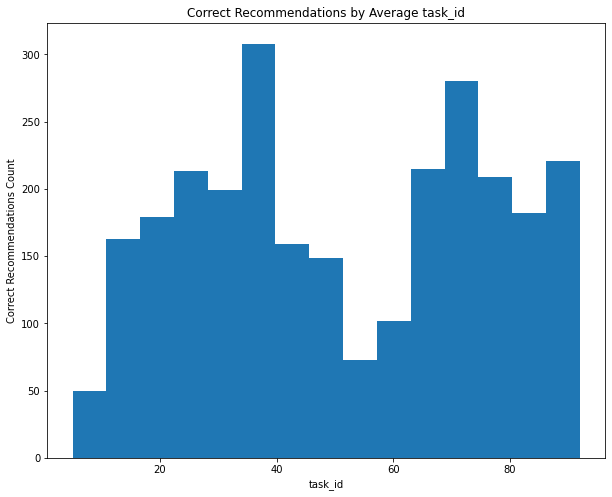

In [18]:
#Average task id - how many times guessed correctly
prediction_list = np.array([])
for key, value in prediction_dict.items():
    prediction_list = np.hstack([prediction_list, [key for _ in range(value)]])
plt.hist(prediction_list, bins=15)
plt.xlabel("task_id")
plt.ylabel("Correct Recommendations Count")
plt.title("Correct Recommendations by Average task_id")
plt.show()